In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.model_selection import learning_curve




import warnings
warnings.filterwarnings('ignore')



In [38]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    print(f"Data shape: {data.shape}")
    return data



In [39]:
def preprocess_data(data):
    # Target variable
    y = data['Heart Disease Mortality']

    columns = data.columns.tolist()
    
    # Remove target variable from features
    if 'Heart Disease Mortality' in columns:
        columns.remove('Heart Disease Mortality')
    
    cat_features = []
    num_features = []
    preprocess_features = []
    
    # Identify categorical, numerical and percentage features
    for col in columns:
        if data[col].dtype == 'object':
            if data[col].astype(str).str.contains('%').any():
                preprocess_features.append(col)
            else:
                cat_features.append(col)
        else:
            num_features.append(col)
    
    # Custom preprocessor to handle percentage features
    class CustomPreprocessor(BaseEstimator, TransformerMixin):
        def __init__(self, preprocess_features):
            self.preprocess_features = preprocess_features
            
        def fit(self, X, y=None):
            return self
            
        def transform(self, X):
            X_processed = X.copy()
            for col in self.preprocess_features:
                if col in X_processed.columns:
                    X_processed[col] = X_processed[col].astype(str).str.replace('%', '').astype(float) / 100
            return X_processed
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    percentage_transformer = Pipeline(steps=[
        ('custom', CustomPreprocessor(preprocess_features)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    transformers = []
    
    if num_features:
        transformers.append(('num', numeric_transformer, num_features))
    
    if cat_features:
        transformers.append(('cat', categorical_transformer, cat_features))
    
    if preprocess_features:
        transformers.append(('pct', percentage_transformer, preprocess_features))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    X = data[columns]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, preprocessor

In [40]:
# Loop for each model train and evaluate it
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):

    # Add 3 new models that we haven't cover in the class
    models = {
        'KNN Regression' : KNeighborsRegressor(n_neighbors=5),
        'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
        'Linear Regression': LinearRegression(),
        'Random Forest Regression': RandomForestRegressor(random_state=42),
        'SGD(new)': SGDRegressor(random_state=42),
        'SVR(new)': SVR(),
        'Neural Network MLP(new)' : MLPRegressor(),
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTrain {name}")
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Model': pipeline
        }
        
        print(f"{name} performence:")
        print(f"  - RMSE: {rmse:.2f}")
        print(f"  - MAE: {mae:.2f}")
        print(f"  - R² Score: {r2:.4f}")
    
    return results



In [41]:
data_path = "../cleaned_data/merged_data.csv" 


In [42]:
data = load_data(data_path)
data.head(10)

Data shape: (32097, 18)


,County,State,Total,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income,Mean income,Heart Disease Mortality,Sex,ethnicity
0,Park,Colorado,"6,987",1.6%,2.9%,10.4%,8.0%,7.0%,18.1%,15.5%,21.1%,10.5%,4.8%,"76,611","91,905",135.9,Female,White
1,Walton,Florida,"28,635",5.9%,3.5%,8.6%,7.9%,12.3%,18.6%,13.8%,17.1%,5.6%,6.7%,"67,390","86,296",126.5,Female,Asian
2,Whitfield,Georgia,"36,412",5.0%,4.6%,12.5%,12.3%,15.5%,20.4%,11.5%,11.9%,2.6%,3.7%,"50,055","67,316",155.1,Female,Hispanic
3,Ida,Iowa,"2,972",7.4%,4.1%,9.1%,9.6%,16.6%,16.5%,16.4%,12.4%,4.5%,3.4%,"54,219","72,389",168.0,Overall,Hispanic
4,Teton,Idaho,"4,290",2.1%,4.6%,7.2%,7.2%,8.5%,21.7%,9.3%,21.1%,15.3%,2.9%,"73,274","93,860",191.9,Female,White
5,Sedgwick,Colorado,954,6.6%,7.7%,17.2%,10.0%,12.4%,15.9%,10.9%,13.5%,2.0%,3.9%,"43,875","66,732",97.8,Female,Asian
6,Shelby,Alabama,"80,756",3.8%,3.0%,6.1%,6.2%,10.8%,17.6%,13.9%,20.7%,8.1%,9.8%,"78,889","103,042",152.3,Female,Hispanic
7,Charles,Maryland,"57,388",3.5%,1.4%,3.5%,4.6%,7.1%,14.1%,13.5%,24.8%,13.6%,13.8%,"103,678","119,477",89.3,Female,Asian
8,Phelps,Missouri,"18,213",10.7%,5.8%,12.5%,9.9%,15.0%,18.1%,10.3%,11.1%,3.7%,2.8%,"44,987","62,126",374.0,Overall,White
9,Mississippi,Arkansas,"16,623",8.3%,6.3%,16.6%,10.8%,14.3%,17.1%,8.5%,11.6%,3.6%,3.0%,"42,986","61,177",167.6,Female,Asian


In [43]:
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(data)

results = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

best_model_name = max(results, key=lambda k: results[k]['R2'])
print(f"\nBest Model: {best_model_name} (R² = {results[best_model_name]['R2']:.4f})")



Train KNN Regression
KNN Regression performence:
  - RMSE: 124.96
  - MAE: 91.53
  - R² Score: 0.3781

Train Decision Tree Regression
Decision Tree Regression performence:
  - RMSE: 116.89
  - MAE: 72.13
  - R² Score: 0.4558

Train Linear Regression
Linear Regression performence:
  - RMSE: 95.99
  - MAE: 63.48
  - R² Score: 0.6330

Train Random Forest Regression
Random Forest Regression performence:
  - RMSE: 101.57
  - MAE: 65.12
  - R² Score: 0.5891

Train SGD(new)
SGD(new) performence:
  - RMSE: 95.89
  - MAE: 63.41
  - R² Score: 0.6338

Train SVR(new)
SVR(new) performence:
  - RMSE: 123.27
  - MAE: 85.90
  - R² Score: 0.3948

Train Neural Network MLP(new)
Neural Network MLP(new) performence:
  - RMSE: 84.81
  - MAE: 51.99
  - R² Score: 0.7135

Best Model: Neural Network MLP(new) (R² = 0.7135)


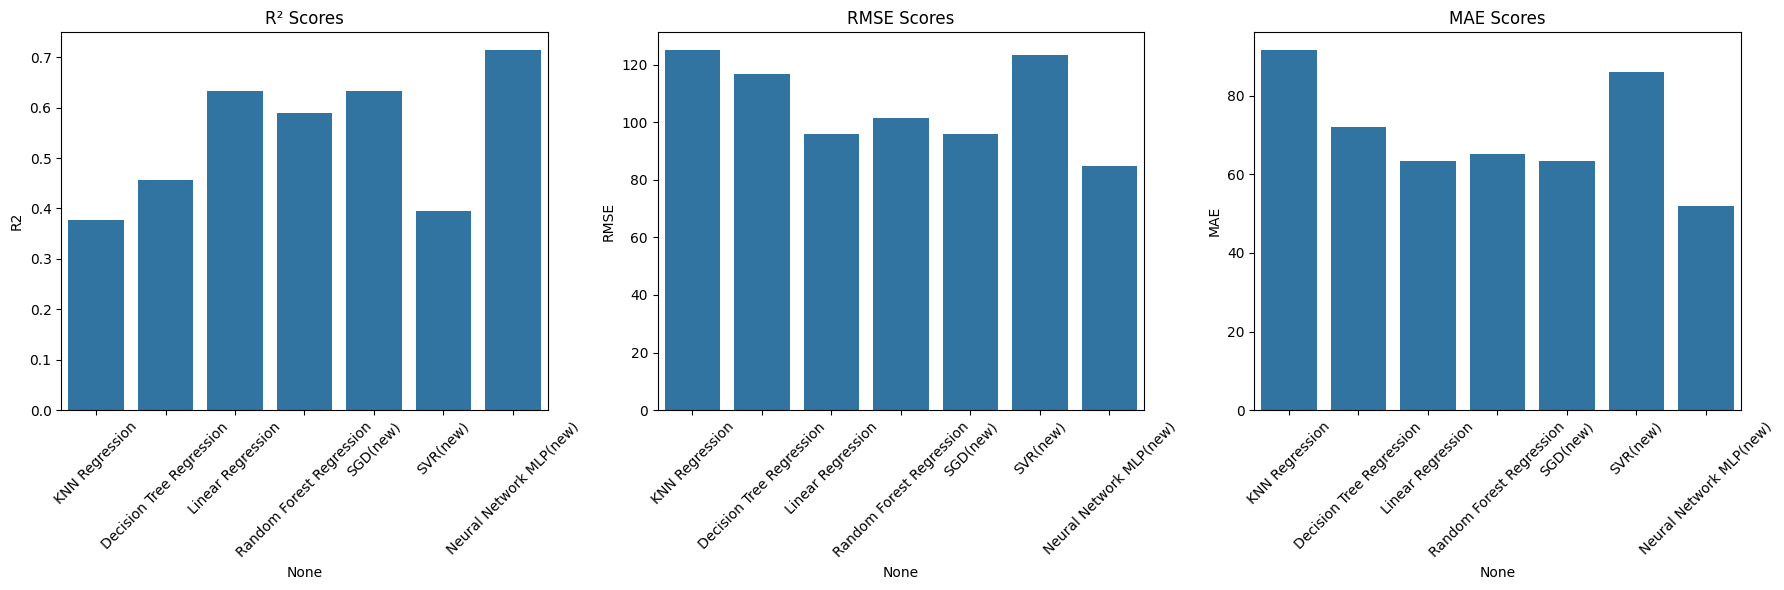

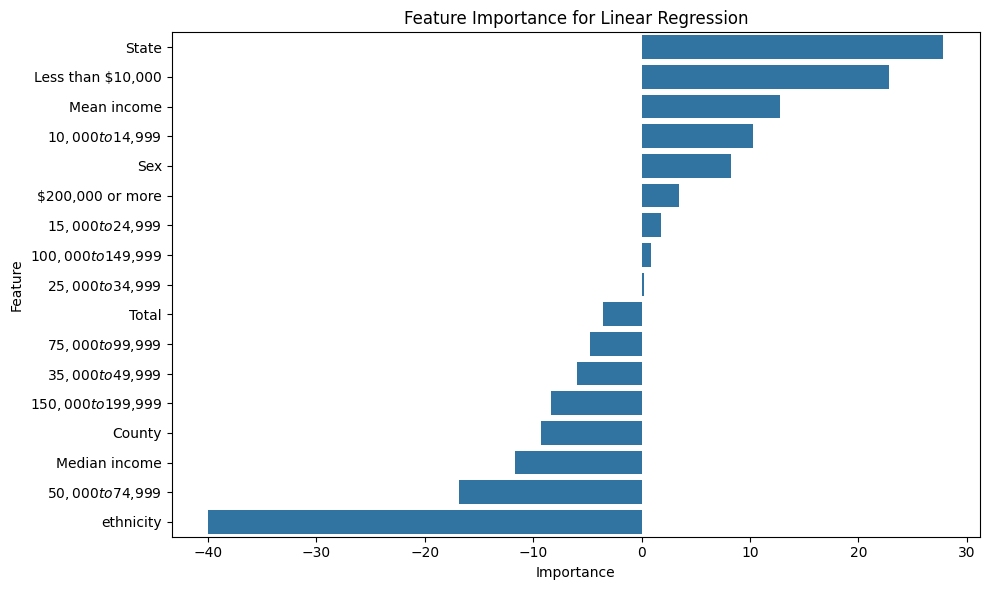

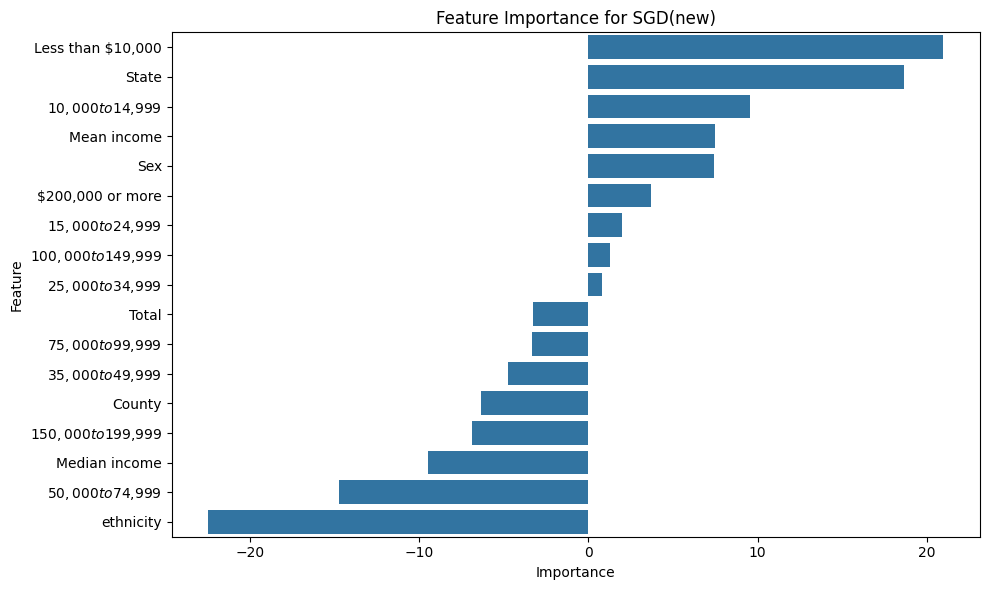

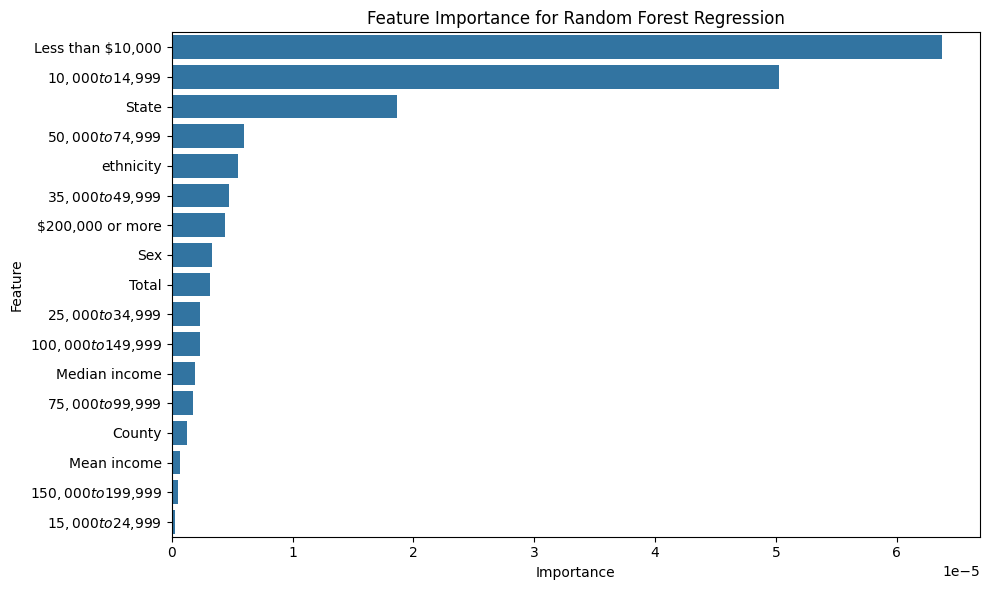

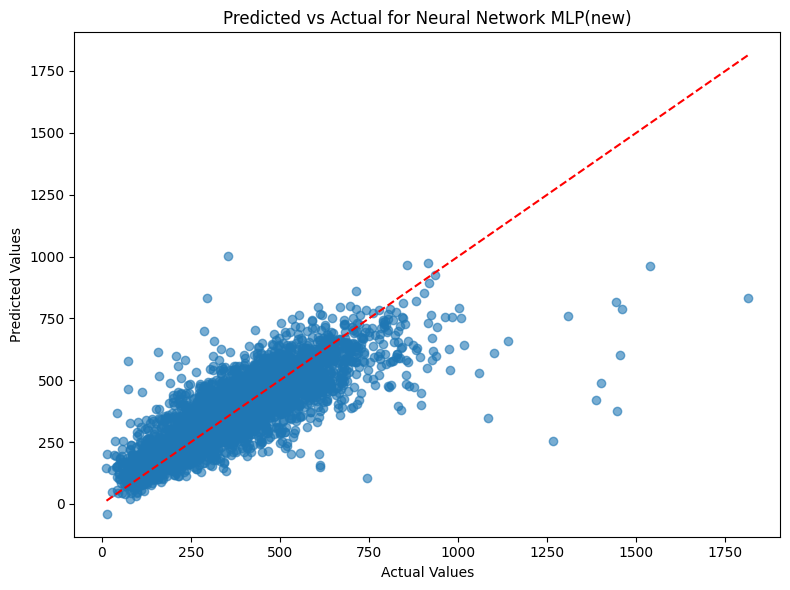

In [57]:
metrics_df = pd.DataFrame({model: {'RMSE': results[model]['RMSE'], 'MAE': results[model]['MAE'], 'R2': results[model]['R2']} for model in results}).T

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['R2'], ax=ax[0])
ax[0].set_title('R² Scores')
sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=ax[1])
ax[1].set_title('RMSE Scores')
sns.barplot(x=metrics_df.index, y=metrics_df['MAE'], ax=ax[2])
ax[2].set_title('MAE Scores')
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig(f'../figure/Model comparison.png')
plt.show()

models_to_plot = ['Linear Regression', 'SGD(new)', 'Random Forest Regression']
for m in models_to_plot:
    pipeline = results[m]['Model']
    estimator = pipeline.named_steps['model']
    try:
        preprocessed_feature_names = pipeline[:-1].get_feature_names_out(input_features=X_train.columns)
    except Exception:
        preprocessed_feature_names = list(X_train.columns)
    if hasattr(estimator, 'coef_'):
        importances = estimator.coef_
    else:
        importances = estimator.feature_importances_
    if len(preprocessed_feature_names) != len(importances):
        min_length = min(len(preprocessed_feature_names), len(importances))
        preprocessed_feature_names = preprocessed_feature_names[:min_length]
        importances = importances[:min_length]
    imp_df = pd.DataFrame({'Feature': preprocessed_feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values('Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=imp_df)
    plt.title(f'Feature Importance for {m}')
    plt.tight_layout()
    plt.savefig(f'../figure/Feature importance for {m}.png')
    plt.show()

best_pipeline = results[best_model_name]['Model']
y_pred_best = best_pipeline.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual for {best_model_name}')
plt.tight_layout()
plt.savefig('../figure/predicted_vs_actual.png')
plt.show()